# LinUCB Hybrid

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
class linucb_hybrid_arm():
    # Note that shared features coefficients beta_hat is calculated outside of each arm since 
    # it is about shared features across individual arms
    
    def __init__(self, d, k, alpha):
        
        # Arm specific A: (d * d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # B: (d * k) matrix
        # Equals to D_a.T * c_a in ridge regression formulation
        self.B = np.zeros([d, k])
        
        # b: (d * 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
        # Alpha hyperparam
        self.alpha = alpha
        
    def init_arm_features(self, arm_index, arm_features_array):
        # Track arm_index
        self.index = arm_index
        
        # arm_features to be used with x_array using outer product to find individual arm z_features
        self.arm_features = arm_features_array
        
        
    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        # beta_hat is the coefficients for Z shared features. (k * 1) vector
        # A_node_inv is (k * k) matrix that is inverse for A_node (shared features)
        
        # Create arm specific z_array with x_array and self.arm_features
        # z_array elements is based on the combination of user and movie features, which is the outer product of both arrays
        # z_array = Outer product = (19 * 29) or (k by d) matrix
        z_array = np.outer(self.arm_features, x_array).reshape(-1,1)
        
        # Find inverse of arm-specific A
        A_inv = np.linalg.inv(self.A)
        
        # Find theta_arm with beta_hat input
        self.theta = np.dot(A_inv, (self.b - np.dot(self.B, beta_hat)))
        
        # std deviation
        s = np.dot(z_array.T, np.dot(A_node_inv, z_array)) \
            - 2 * np.dot(z_array.T, np.dot(A_node_inv, np.dot(self.B.T, np.dot(A_inv, x_array)))) \
            + np.dot(x_array.T, np.dot(A_inv, x_array)) \
            + np.dot(x_array.T, np.dot(A_inv, np.dot(self.B, np.dot(A_node_inv, np.dot(self.B.T, np.dot(A_inv, x_array))))))
        
        
        # UCB
        p = np.dot(z_array.T, beta_hat) + np.dot(x_array.T, self.theta) + self.alpha*np.sqrt(s)
        
        return p
    
    def reward_update(self, reward, x_array, z_array):
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)
        
        # Update B which is (d * k) matrix.
        self.B += np.dot(x_array, z_array.T)
        
        # Update b which is (d * 1) vector
        # reward is scalar
        self.b += reward * x_array                          
        

In [36]:
class linucb_hybrid_policy():
    
    def __init__(self, K_arms, d, k, alpha, epsilon):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_hybrid_arm(d = d, k = k, alpha = alpha) for i in range(K_arms)]
        
        # shared A_node: (k * k) matrix
        self.A_node = np.identity(k)
        
        # shared b_node: (k * 1) corresponding response vector. 
        self.b_node = np.zeros([k,1])
        
        self.epsilon = epsilon
        
    def store_arm_features(self, arms_features_array):
        # Arms_features_array is multidimension array of shape (K_arms, 1+arm_dimensions), where 1 is for arm_index
    
        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):
        
            self.linucb_arms[i].init_arm_features(arm_index = arms_features_array[i,0], 
                                                  arm_features_array = arms_features_array[i,1:])
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Create inverse of A_node to be fed in
        A_node_inv = np.linalg.inv(self.A_node)
        
        
        # Calc beta_hat using A_node_inv and b_node.
        # (k * 1) vector
        beta_hat = np.dot(A_node_inv, self.b_node)
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array, A_node_inv, beta_hat)
            
            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)
        
        # Add epsilon probability to choose random arm
        if self.epsilon:
            if np.random.rand() < self.epsilon:
                return np.random.choice(np.arange(self.K_arms))
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm_index = np.random.choice(candidate_arms)
        
        return chosen_arm_index
    
    def update_shared_features_matrices_phase1(self, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        # Use chosen arm's B (d*k), A(d*d), b(k*1) for update of shared feature matrices
        
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        self.A_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B))
        self.b_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))
        
    def update_shared_features_matrices_phase2(self, z_array, reward, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        self.A_node += np.dot(z_array, z_array.T) - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B)) 
        self.b_node += reward * z_array - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))
    

In [37]:
def ctr_simulator(K_arms, d, k, alpha, epochs, top_movies_index, top_movies_features, steps_printout, epsilon=None):
    # Initiate policy
    linucb_hybrid_policy_object = linucb_hybrid_policy(K_arms=K_arms, d=d, k=k, alpha=alpha, epsilon=epsilon)
    
    # Store arm specific features
    linucb_hybrid_policy_object.store_arm_features(top_movies_features.to_numpy())
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Initialize empty DataFrame for unused data
    unused_data = pd.DataFrame(columns=["user_id", "movie_id", "rating", "reward"])
    
    for epoch_iter in range(epochs):
        
        print("Epoch: " + str(epoch_iter))
        
        if epoch_iter == 0:
            # Start with filtered data first
            data = filtered_data.copy()
        else:
            # Recycle unused data
            data = unused_data.copy().reset_index(drop=True)
            # Reinitialize unused_data DataFrame
            unused_data = pd.DataFrame(columns=["user_id", "movie_id", "rating", "reward"])
        
        for i in range(len(data)):
            user_id = data.loc[i, "user_id"]
            movie_id = data.loc[i, "movie_id"]

            # x_array: User features
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis=1)) # Shape (1 * 29), d = 29
            data_x_array = data_x_array.reshape(29, 1)

            # Obtain rewards
            data_reward = data.loc[i, "reward"]

            if i % steps_printout == 0:
                print("step " + str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_hybrid_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (i.e., same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].index == movie_id:
                # Phase 1: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase1(
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b
                )
                
                # Extract chosen_arm arm_features to create z_array
                data_z_array = np.outer(
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].arm_features, 
                    data_x_array
                ).reshape(-1, 1)
                
                # Use reward information for the chosen arm to update
                linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].reward_update(
                    data_reward, data_x_array, data_z_array
                )

                # Phase 2: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase2(
                    data_z_array,
                    data_reward,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b
                )

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards / aligned_time_steps)
            else:
                # Recycle data
                unused_data = pd.concat([unused_data, data.iloc[[i]]], ignore_index=True)

    return {
        "aligned_time_steps": aligned_time_steps, 
        "cumulative_rewards": cumulative_rewards, 
        "aligned_ctr": aligned_ctr, 
        "policy": linucb_hybrid_policy_object
    }


# Data Preprocessing

In [8]:
from sklearn.preprocessing import OneHotEncoder

## User data 

In [9]:
user = pd.read_csv("../data/ml-100k/u.user", header = None, sep = "|")
user.columns = ["user_id","age","gender","occupation","zipcode"]
user = user.drop(["zipcode"], axis = 1)

In [10]:
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

user['agegroup'] = pd.cut(user['age'], bins, labels=names)
user = user.drop(["age"], axis = 1)
user.head()

,user_id,gender,occupation,agegroup
0,1,M,technician,20-29
1,2,F,other,51-60
2,3,M,writer,20-29
3,4,M,technician,20-29
4,5,F,other,30-39


In [11]:
columnsToEncode = ["agegroup","gender","occupation"]
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columns= columnsToEncode, axis=1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names_out(columnsToEncode))], axis=1).reindex()

/Users/sungjuyong/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
user_features.head()

,user_id,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_60+,agegroup_<20,gender_F,gender_M,occupation_administrator,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Movie Data (Arm)

In [13]:
movie = pd.read_csv("../data/ml-100k/u.item", header = None, sep = "|", encoding='latin-1')
movie.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", 
                  "unknown", "Action", "Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy",
                  "Film-Noir","Horror", "Musical", "Mystery","Romance","Sci-Fi","Thriller", "War","Western"]

In [14]:
movie_features = movie.drop(["movie_title","release_date", "video_release_date", "IMDb_URL"],axis = 1)
movie_features

,movie_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Stream data of users with movie ratings & reward

In [15]:
data = pd.read_csv("../data/ml-100k/u.data", sep ="\t", header=None, names = ["user_id", "movie_id","rating", "timestamp"])
data = data.drop(["timestamp"], axis = 1)

In [16]:
n = 30

# Find total number of ratings instances for top n movies
data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n)["rating"].sum()

11995

In [17]:
# Obtain top movies index
top_movies_index = data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n).reset_index()["movie_id"]

In [18]:
top_movies_features = movie_features[movie_features.movie_id.isin(top_movies_index)]

In [19]:
top_movies_features.to_numpy().shape

(30, 20)

In [20]:
filtered_data_original = data[data["movie_id"].isin(top_movies_index)]

filtered_data_original.head()

,user_id,movie_id,rating
12,200,222,5
24,308,1,4
31,301,98,4
50,251,100,4
53,25,181,5


In [21]:
filtered_data_original["reward"] = np.where(filtered_data_original["rating"] <5,0,1)

filtered_data_original = filtered_data_original.reset_index(drop = True)

/var/folders/0d/twd9n1ns6vv6d0fjbj08p_q40000gn/T/ipykernel_54955/1568349636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_original["reward"] = np.where(filtered_data_original["rating"] <5,0,1)


In [22]:
filtered_data_original.head()

,user_id,movie_id,rating,reward
0,200,222,5,1
1,308,1,4,0
2,301,98,4,0
3,251,100,4,0
4,25,181,5,1


<Axes: >

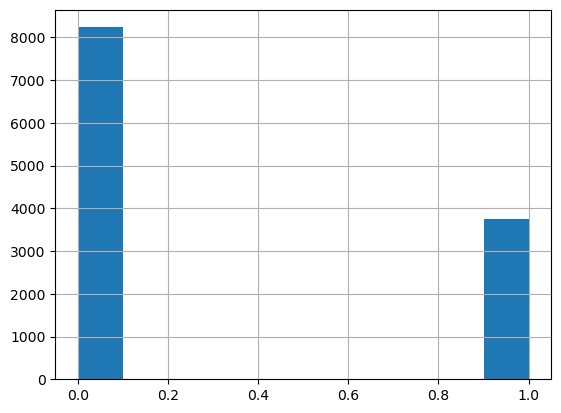

In [23]:
filtered_data_original.reward.hist()

In [24]:
reward_mean = filtered_data_original.reward.mean()
reward_mean

0.3134639433097124

In [25]:
# Reshuffling rows to randomise it
np.random.seed(100)
filtered_data = filtered_data_original.reindex(np.random.permutation(filtered_data_original.index)).reset_index(drop = True)

In [38]:
alpha_value = 0.5
simulation_hybrid_alpha_05 = ctr_simulator(
    K_arms=n, 
    d=29, 
    alpha=alpha_value, 
    epochs=4, 
    top_movies_index=top_movies_index, 
    top_movies_features=top_movies_features,
    steps_printout=5000,
    epsilon=None
)

simulation_hybrid_alpha_05_1 = ctr_simulator(
    K_arms=n, 
    d=29,
    k=29*19,
    alpha=alpha_value, 
    epochs=4, 
    top_movies_index=top_movies_index, 
    top_movies_features=top_movies_features,
    steps_printout=5000,
    epsilon=0.1
)


Epoch: 0
step 0


KeyboardInterrupt: 

In [29]:
print(simulation_hybrid_alpha_05)

{'aligned_time_steps': 784, 'cumulative_rewards': 297, 'aligned_ctr': [0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.2857142857142857, 0.25, 0.2222222222222222, 0.3, 0.36363636363636365, 0.4166666666666667, 0.46153846153846156, 0.5, 0.5333333333333333, 0.5625, 0.5294117647058824, 0.5, 0.47368421052631576, 0.45, 0.47619047619047616, 0.45454545454545453, 0.43478260869565216, 0.4166666666666667, 0.44, 0.46153846153846156, 0.4444444444444444, 0.4642857142857143, 0.4482758620689655, 0.43333333333333335, 0.45161290322580644, 0.46875, 0.45454545454545453, 0.4411764705882353, 0.45714285714285713, 0.4444444444444444, 0.43243243243243246, 0.42105263157894735, 0.4358974358974359, 0.45, 0.43902439024390244, 0.4523809523809524, 0.4418604651162791, 0.45454545454545453, 0.4444444444444444, 0.45652173913043476, 0.44680851063829785, 0.4375, 0.42857142857142855, 0.42, 0.43137254901960786, 0.4230769230769231, 0.41509433962264153, 0.4074074074074074, 0.41818181818181815, 0.41071428571428

Text(0.5, 1.0, 'alpha = 0.5')

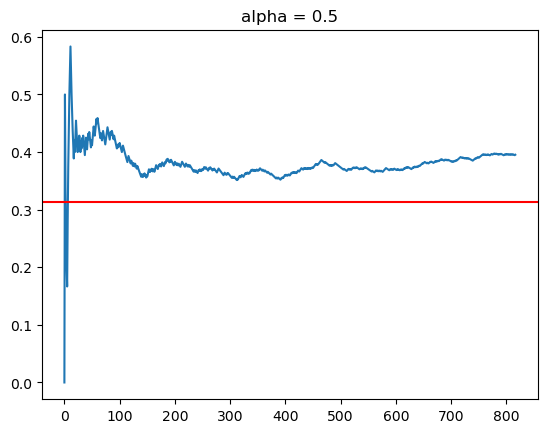

In [35]:
plt.plot(simulation_hybrid_alpha_05["aligned_ctr"], label="epsilon=None")

plt.plot(simulation_hybrid_alpha_05_1["aligned_ctr"], label="epsilon=0.1")

plt.axhline(y=reward_mean, color="red", linestyle="--", label="Reward Mean")

plt.title("Comparison of CTR for alpha = 0.5")
plt.xlabel("Time Steps")
plt.ylabel("Average Reward")

plt.legend()

Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000


Text(0.5, 1.0, 'alpha = 1.0')

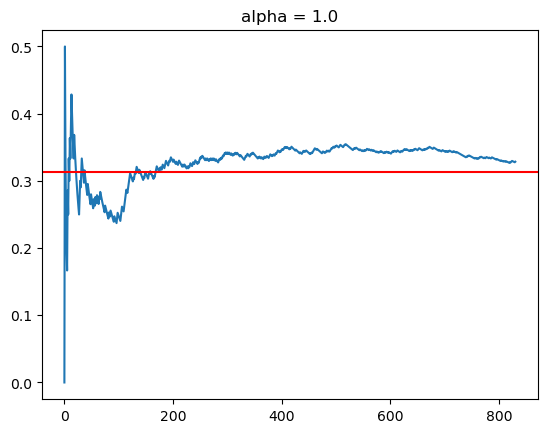

In [36]:
alpha_value = 1.0
simulation_hybrid_alpha_10 = ctr_simulator(K_arms = n, 
                                           d = 29,
                                           k = 29*19,
                                           alpha = alpha_value, 
                                           epochs = 2, 
                                           top_movies_index = top_movies_index, 
                                           top_movies_features=top_movies_features,
                                           steps_printout=5000)
plt.plot(simulation_hybrid_alpha_10["aligned_ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = "+str(alpha_value))

Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000


Text(0.5, 1.0, 'alpha = 1.5')

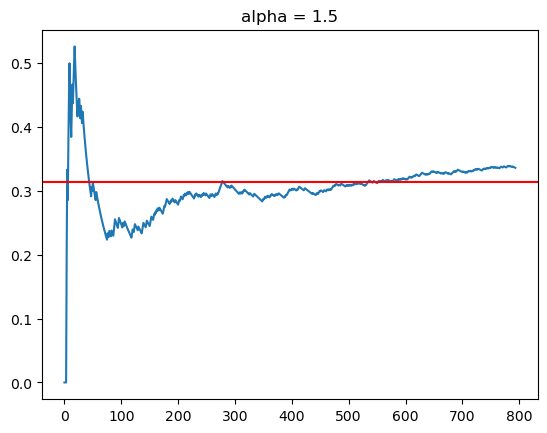

In [37]:
alpha_value = 1.5
simulation_hybrid_alpha_15 = ctr_simulator(K_arms = n, 
                                           d = 29,
                                           k = 29*19,
                                           alpha = alpha_value, 
                                           epochs = 2, 
                                           top_movies_index = top_movies_index, 
                                           top_movies_features=top_movies_features,
                                           steps_printout=5000)
plt.plot(simulation_hybrid_alpha_15["aligned_ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = "+str(alpha_value))

Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000


Text(0.5, 1.0, 'alpha = 0.25')

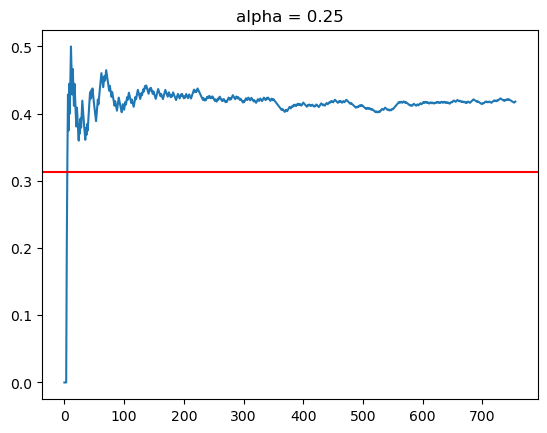

In [38]:
alpha_value = 0.25
simulation_hybrid_alpha_025 = ctr_simulator(K_arms = n, 
                                           d = 29,
                                           k = 29*19,
                                           alpha = alpha_value, 
                                           epochs = 2, 
                                           top_movies_index = top_movies_index, 
                                           top_movies_features=top_movies_features,
                                           steps_printout=5000)
plt.plot(simulation_hybrid_alpha_025["aligned_ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = "+str(alpha_value))

## LinUCB Disjoint Simulation

In [ ]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x_array) +  self.alpha * np.sqrt(np.dot(x_array.T, np.dot(A_inv,x_array)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x_array

In [ ]:
class linucb_disjoint_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
        
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            
            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm = np.random.choice(candidate_arms)
        
        return chosen_arm
    
    def store_arm_index(self, arms_index_array):
    # Arms_features_array is multidimension array of shape (K_arms, 1+arm_dimensions), where 1 is for arm_index

        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):

            self.linucb_arms[i].arm_index = arms_index_array[i]

In [ ]:
def ctr_disjoint_simulator(K_arms, d, alpha, epochs, top_movies_index, steps_printout):
    # Initiate policy
    linucb_disjoint_policy_object = linucb_disjoint_policy(K_arms = K_arms, d = d, alpha = alpha)
    
    # Store specific arm_index
    linucb_disjoint_policy_object.store_arm_index(top_movies_index.to_numpy())
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    for epoch_iter in range(epochs):
        
        print("Epoch: " + str(epoch_iter))
        
        if epoch_iter == 0:
            # Start with filtered data first
            data = filtered_data.copy()
            # Initiate unused_data df
            unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])
        else:
            
            # Recycle unused data
            data = unused_data.copy().reset_index(drop = True)
            # Initiate unused_data df
            unused_data = pd.DataFrame(columns = ["user_id", "movie_id","rating","reward"])
        
        for i in range(len(data)):

            user_id = data.loc[i,"user_id"]
            movie_id = data.loc[i, "movie_id"]

            # x_array: User features
            data_x_array = np.array(user_features.query("user_id == @user_id").drop("user_id", axis = 1)) # Shape (1 * 29), d = 29
            data_x_array = data_x_array.reshape(29,1)

            # Obtain rewards
            data_reward = data.loc[i, "reward"]

            if i%steps_printout == 0:
                print("step "+str(i))

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_disjoint_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].arm_index  == movie_id:

                # Use reward information for the chosen arm to update
                linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].reward_update(data_reward, data_x_array)
                
                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
            
            else:
                # Recycle data
                unused_data = unused_data.append(data.iloc[i])
                    
    return {"aligned_time_steps": aligned_time_steps, 
            "cumulative_rewards": cumulative_rewards, 
            "aligned_ctr":aligned_ctr, 
            "policy":linucb_disjoint_policy_object}

# Compare Disjoint vs Hybrid (alpha = 0.25) for a single simulation run

Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000


Text(0.5, 1.0, 'alpha = 0.25')

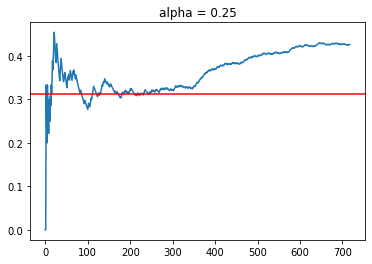

In [ ]:
alpha_value = 0.25
simulation_disjoint_alpha_025 = ctr_disjoint_simulator(K_arms = n, 
                                                       d = 29,
                                                       alpha = alpha_value, 
                                                       epochs = 2, 
                                                       top_movies_index = top_movies_index, 
                                                       steps_printout=5000)
plt.plot(simulation_disjoint_alpha_025["aligned_ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("alpha = "+str(alpha_value))

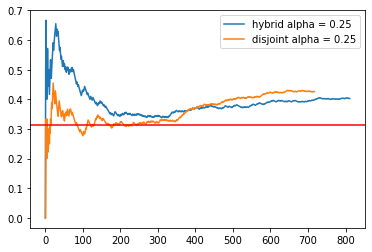

In [ ]:
plt.plot(simulation_hybrid_alpha_025["aligned_ctr"], label = "hybrid alpha = 0.25")
plt.plot(simulation_disjoint_alpha_025["aligned_ctr"], label = "disjoint alpha = 0.25")
plt.axhline(y=reward_mean, color = "red")
plt.legend()

# Compare Disjoint vs Hybrid (alpha = 0.25) for multiple simulations
- 100 simulations based on randomised permutations of the filtered data using different seeds
- Took 24 hours for non-parallelised job

In [ ]:
hybrid_ctr =[]
disjoint_ctr = []

alpha_value = 0.25

for i in range(100):
    
    # Shuffling data order based on random seed
    np.random.seed(i)
    filtered_data = filtered_data_original.reindex(np.random.permutation(filtered_data_original.index)).reset_index(drop = True)
    
    # Hybrid policy
    simulation_hybrid_alpha_025 = ctr_simulator(K_arms = n, 
                                               d = 29,
                                               k = 29*19,
                                               alpha = alpha_value, 
                                               epochs = 2, 
                                               top_movies_index = top_movies_index, 
                                               top_movies_features=top_movies_features,
                                               steps_printout=5000)
    hybrid_ctr.append(simulation_hybrid_alpha_025["aligned_ctr"])
    
    # Disjoint policy
    simulation_disjoint_alpha_025 = ctr_disjoint_simulator(K_arms = n, 
                                                           d = 29,
                                                           alpha = alpha_value, 
                                                           epochs = 2, 
                                                           top_movies_index = top_movies_index, 
                                                           steps_printout=5000)
    disjoint_ctr.append(simulation_disjoint_alpha_025["aligned_ctr"])

# Find min time step
min_len = 5000

for i in range(100):
    if len(hybrid_ctr[i]) < min_len or len(disjoint_ctr[i]) < min_len:
        min_len = min(len(hybrid_ctr[i]), len(disjoint_ctr[i]))
                      
# Initiate list for storing shortened ctr based on the min time steps
shorten_hybrid_ctr = []
shorten_disjoint_ctr = []

for i in range(100):
    # Shortening all ctr to common time steps
    shorten_hybrid_ctr.append(hybrid_ctr[i][:min_len])
    shorten_disjoint_ctr.append(disjoint_ctr[i][:min_len])

avg_hybrid_ctr = np.array(shorten_hybrid_ctr).mean(axis = 0)
avg_disjoint_ctr = np.array(shorten_disjoint_ctr).mean(axis = 0)

Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
Epoch: 1
step 0
step 5000
step 10000
Epoch: 0
step 0
step 5000
step 10000
E

### Important saving of objects after 24 hour compute job!

In [ ]:
import pickle

# with open('avg_hybrid_ctr.pickle', 'wb') as handle:
#     pickle.dump(avg_hybrid_ctr, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('hybrid_ctr.pickle', 'wb') as handle:
#     pickle.dump(hybrid_ctr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('avg_disjoint_ctr.pickle', 'wb') as handle:
#     pickle.dump(avg_disjoint_ctr, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('disjoint_ctr.pickle', 'wb') as handle:
#     pickle.dump(disjoint_ctr, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
with open('avg_hybrid_ctr.pickle', 'rb') as handle:
     avg_hybrid_ctr = pickle.load(handle)

with open('avg_disjoint_ctr.pickle', 'rb') as handle:
     avg_disjoint_ctr = pickle.load(handle)

# Screwed up I lost by overwriting the file 
# with open('hybrid_ctr.pickle', 'rb') as handle:
#     hybrid_ctr = pickle.load(handle)
    
with open('disjoint_ctr.pickle', 'rb') as handle:
    disjoint_ctr = pickle.load(handle)
        

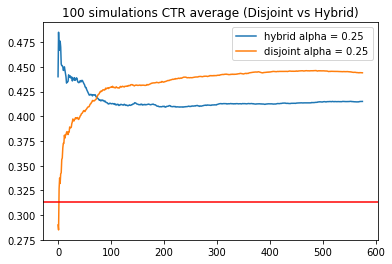

In [ ]:
plt.plot(avg_hybrid_ctr, label = "hybrid alpha = 0.25")
plt.plot(avg_disjoint_ctr, label = "disjoint alpha = 0.25")
plt.axhline(reward_mean, color = "red")
plt.title("100 simulations CTR average (Disjoint vs Hybrid)")
plt.legend()
